*Load Drive*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Import Libraries*

In [ ]:
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np# Keras API
import keras
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

*Load Training and Testing Set*

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/train_drowsy'
test_path = '/content/drive/MyDrive/Colab Notebooks/test_drowsy'
val_path = '/content/drive/MyDrive/Colab Notebooks/test_drowsy'

*Count number of training and testing Images*

In [ ]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0

  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

*Display the number*

In [ ]:
train_samples = get_files(train_path)
num_classes = len(glob.glob(train_path+"/*"))
test_samples = get_files(test_path)
val_samples = get_files(val_path)

print("Number of classes is", num_classes)
print("Number of training samples is", train_samples)
print("Number of testing samples is", test_samples)
print("Number of validation samples is", val_samples)

Number of classes is 2
Number of training samples is 2420
Number of testing samples is 610
Number of validation samples is 610


*Image Augmentation*

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
img_width, img_height = 50, 50

input_shape = (img_width, img_height, 3)

batch_size = 32

train_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size = (img_width, img_height),
                                                   batch_size = batch_size)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  shuffle = False,
                                                  target_size = (img_width, img_height),
                                                  batch_size = batch_size)

val_generator = val_datagen.flow_from_directory(val_path,
                                                shuffle = False,
                                                target_size = (img_width, img_height),
                                                batch_size = batch_size)
# Get x_train and y_train
x_train, y_train = train_generator.next()

# Get x_test and y_test
x_test, y_test = test_generator.next()

# Get x_val and y_val
x_val, y_val = val_generator.next()

Found 2420 images belonging to 2 classes.
Found 610 images belonging to 2 classes.
Found 610 images belonging to 2 classes.


*Get Class Index*

In [ ]:
train_generator.class_indices

{'Drowsy': 0, 'Not Drowsy': 1}

*Build CNN Parameters*

In [ ]:
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 64)          0

*Build Model*

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile the model with the specified optimizer, loss, and metrics
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True)

model_checkpoint = ModelCheckpoint(
    'new_drowsiness_model.h5',
    monitor = 'val_accuracy',
    save_best_only = True)

# Train the model with the specified callbacks
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    validation_data = test_generator,
    validation_steps = len(test_generator),
    verbose = 1,
    epochs = 50,
    callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/50
76/76 [==============================] - 1416s 19s/step - loss: 0.4918 - accuracy: 0.7686 - val_loss: 0.4381 - val_accuracy: 0.8164
Epoch 2/50
 1/76 [..............................] - ETA: 7s - loss: 0.2544 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 [==============================] - 8s 110ms/step - loss: 0.2829 - accuracy: 0.8946 - val_loss: 0.3308 - val_accuracy: 0.8770
Epoch 3/50
76/76 [==============================] - 8s 104ms/step - loss: 0.2391 - accuracy: 0.9045 - val_loss: 0.2486 - val_accuracy: 0.9049
Epoch 4/50
76/76 [==============================] - 9s 113ms/step - loss: 0.1933 - accuracy: 0.9343 - val_loss: 0.1949 - val_accuracy: 0.9230
Epoch 5/50
76/76 [==============================] - 7s 98ms/step - loss: 0.1817 - accuracy: 0.9364 - val_loss: 0.2166 - val_accuracy: 0.9098
Epoch 6/50
76/76 [==============================] - 9s 112ms/step - loss: 0.1473 - accuracy: 0.9500 - val_loss: 0.1462 - val_accuracy: 0.9344
Epoch 7/50
76/76 [==============================] - 8s 110ms/step - loss: 0.1455 - accuracy: 0.9455 - val_loss: 0.1295 - val_accuracy: 0.9492
Epoch 8/50
76/76 [==============================] - 8s 99ms/step - loss: 0.1358 - accuracy: 0.9529 - val_loss: 0.1655 - val_accuracy: 0.9344
Epoch 9/50
76/76 [=

*Plot Accuracy and Losses*

In [ ]:
import matplotlib.pyplot as plt

# Extract data from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Plot Training and Validation accuracy
axs[0].plot(epochs, acc, 'b', label='Training accuracy')
axs[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot Training and Validation loss
axs[1].plot(epochs, loss, 'b', label='Training loss')
axs[1].plot(epochs, val_loss, 'r', label='Validation loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

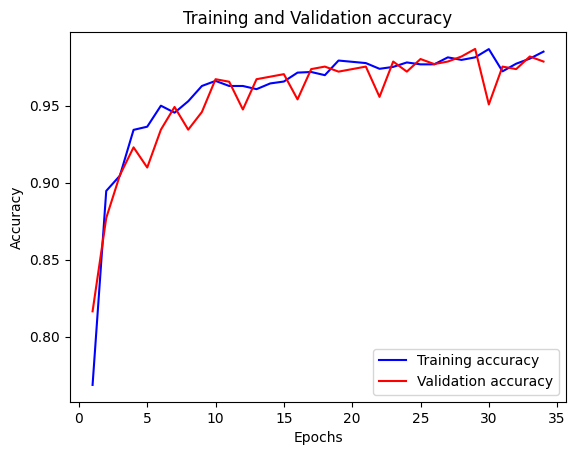

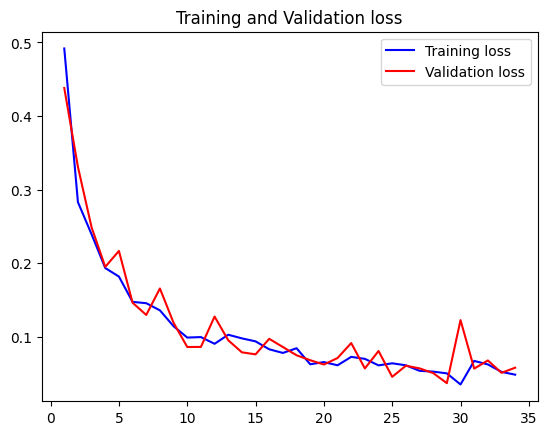

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

*Evaluate Model Accuracy*

In [ ]:
score,accuracy = model.evaluate(val_generator, verbose = 1)
print("Validation score is {:.2f}%".format(score*100))
print("Validation accuracy is {:.2f}%".format(accuracy*100))

20/20 [==============================] - 1s 51ms/step - loss: 0.0368 - accuracy: 0.9869
Validation score is 3.68%
Validation accuracy is 98.69%


*Load Saved Model for Testing*

In [ ]:
from keras.models import load_model
model=load_model('/content/new_drowsiness_model.h5')

Classes = ['Drowsy', 'Non_Drowsy']

*Classification Report*

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
y_test = test_generator.classes

# predicting our model with test dataset i.e. unseen dataset
pred = model.predict(test_generator, test_samples//batch_size+1,verbose=1,).argmax(axis=1)

#print(y_test)
print(pred)

#Classification report of every label
print(classification_report(y_test, pred, target_names = Classes))

20/20 [==============================] - 1s 57ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

*Prediction Accuracy*

In [ ]:
correct = 0
incorrect = 0
for i in range(len(y_test)):

    #print("Test Sample is: ", y_test[i], "while predicted sample is: ", pred[i])

    if y_test[i] != pred[i]:
        incorrect += 1
    else:
        correct += 1

print('Total number of test cases', ((len(y_test))))
print('Number of correct predictions', correct)
print('Number of incorrect predictions', incorrect)

Total number of test cases 610
Number of correct predictions 602
Number of incorrect predictions 8


*Plot Confusion Matrix*

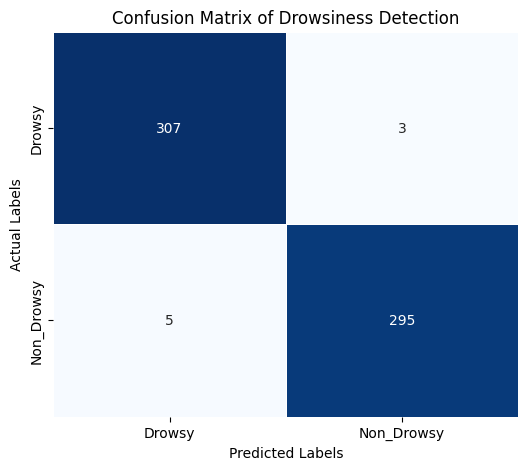

In [ ]:
import pandas as pd
import seaborn as sn

# Create a confusion matrix
conf_mat = confusion_matrix(y_test, pred)

# Create a DataFrame from the confusion matrix
conf_df = pd.DataFrame(conf_mat, columns = Classes, index = Classes)

# Plot the confusion matrix using seaborn with annotated actual and predicted labels
plt.figure(figsize = (6, 5))
plt.title('Confusion Matrix of Drowsiness Detection')
sn.heatmap(conf_df, fmt = "d", cmap = "Blues", annot = True, cbar = False, linewidths = .5)

# Add x and y axis labels
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

plt.show()

*Test Single Image*

In [ ]:
from google.colab import files
from keras.models import load_model
from PIL import Image
import numpy as np
from IPython.display import display, Image as IPImage, Audio

# Upload the Keras model file (replace 'best_drowsiness_model.h5' with your actual model file)
uploaded = files.upload()

# Load the model
model = load_model('/content/new_drowsiness_model.h5')  # Replace 'best_drowsiness_model.h5' with your actual model file

# Define your classes (replace 'Classes' with your actual class labels)
Classes = ['Drowsy', 'Non_Drowsy']

def classify_image(file_path):
    test_image = Image.open(file_path)
    test_image = test_image.resize((50, 50))
    test_image = np.expand_dims(np.array(test_image), axis=0)

    result = model.predict(test_image)
    predicted_class = np.argmax(result)
    sign = Classes[predicted_class]

    print(f'The Predicted class is: {predicted_class}')
    print(f'The Predicted sign is: {sign}')

    # Display the image
    display(IPImage(filename=file_path))

    # Check if drowsy is detected and play an alarm sound
    if sign == 'Drowsy':
        alarm_sound_url = 'https://www.soundhelix.com/examples/mp3/SoundHelix-Song-1.mp3'  # Replace with your alarm sound URL
        display(Audio(url=alarm_sound_url, autoplay=True))

# Ask the user to choose a file
file_path = list(uploaded.keys())[0]  # Get the first uploaded file
classify_image(file_path)

Saving s0001_00039_0_0_0_0_0_01.png to s0001_00039_0_0_0_0_0_01.png


ValueError: ignored